# Computer Vision CSCI-GA.2272-001 Assignment 2

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

In [2]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

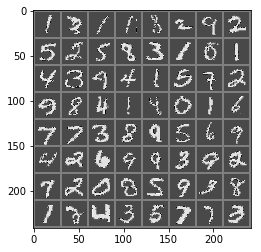

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.


(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


In [6]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [7]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # wrap inputs in Variable
        data, target = Variable(data), Variable(target)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [8]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.456281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.490128
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.577770
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.420442
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.351943
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.266968
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.317580
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.419647
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.209406
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.382990

Test set: Average loss: 0.3352, Accuracy: 9044/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.301122
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.499045
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.297774
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.420682
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.368403
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.315756
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.375409
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.336774
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.351886
T

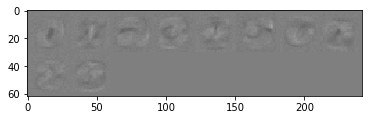

In [9]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.view(10,1,28,28)))

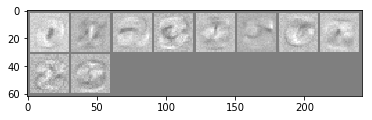

In [10]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.view(10,1,28,28),normalize=True, scale_each=True))

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.


In [11]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements sequentially, always in the same order.
    Arguments:
        data_source (Dataset): dataset to sample from
        num_samples (int): number of samples to draw
    """

    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples < len(self.data_source):
            self.num_samples = num_samples
        else:
            self.num_samples = len(self.data_source)
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [12]:
subset_sampler = SubsetSampler(trainset, 50)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, sampler=subset_sampler, num_workers=0)
subset_sampler = SubsetSampler(testset, 50)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=subset_sampler, num_workers=0)

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [13]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.599471

Test set: Average loss: 0.0121, Accuracy: 6/10000 (0%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.357929

Test set: Average loss: 0.0115, Accuracy: 9/10000 (0%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.155651

Test set: Average loss: 0.0111, Accuracy: 13/10000 (0%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.980205

Test set: Average loss: 0.0106, Accuracy: 15/10000 (0%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.825399

Test set: Average loss: 0.0103, Accuracy: 20/10000 (0%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.687617

Test set: Average loss: 0.0099, Accuracy: 22/10000 (0%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.564458

Test set: Average loss: 0.0096, Accuracy: 22/10000 (0%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 1.454092

Test set: Average loss: 0.0093, Accuracy: 22/10000 (0%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 1.354983

Test set: Average loss: 0.0090, Accuracy: 22/10000 (0%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 1.265796

Test set: Average loss: 0.00

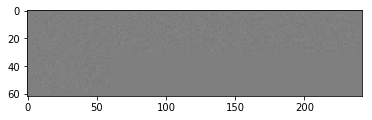

In [14]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.view(10,1,28,28)))

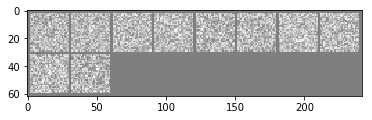

In [15]:
for x in network.modules():
    if isinstance(x, nn.Linear):           
        imshow(utils.make_grid(x.weight.data.view(10,1,28,28),normalize=True, scale_each=True))

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.


In [25]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [26]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372574
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.760013
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.454419
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.431221
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.455542
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.311673
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.659995
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.232487
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.413918
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.319770

Test set: Average loss: 0.3237, Accuracy: 9096/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.366386
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.203871
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.305137
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.367994
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.166384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.361276
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.267880
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.217740
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.329431
T

-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

In [28]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

network = Net(num_inputs, num_outputs, hidden_units=1000)
optimizer = optim.SGD(network.parameters(), lr=10)

In [29]:
for epoch in range(1, 1 + epochs):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327770
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1140.284424
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1169.257690
Train Epoch: 1 [19200/60000 (32%)]	Loss: 912.864563
Train Epoch: 1 [25600/60000 (43%)]	Loss: 985.016174
Train Epoch: 1 [32000/60000 (53%)]	Loss: 465.178436
Train Epoch: 1 [38400/60000 (64%)]	Loss: 345.676331
Train Epoch: 1 [44800/60000 (75%)]	Loss: 243.956039
Train Epoch: 1 [51200/60000 (85%)]	Loss: 468.496002
Train Epoch: 1 [57600/60000 (96%)]	Loss: 420.082367

Test set: Average loss: 303.0990, Accuracy: 6244/10000 (62%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 397.112122
Train Epoch: 2 [6400/60000 (11%)]	Loss: 515.105103
Train Epoch: 2 [12800/60000 (21%)]	Loss: 573.730103
Train Epoch: 2 [19200/60000 (32%)]	Loss: 270.658234
Train Epoch: 2 [25600/60000 (43%)]	Loss: 189.607910
Train Epoch: 2 [32000/60000 (53%)]	Loss: 997.530945
Train Epoch: 2 [38400/60000 (64%)]	Loss: 150.540421
Train Epoch: 2 [44800/60000 (75%)]	Loss: 454.340271
Train Epoch: 

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [ ]:
dataset = 'cifar10'
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)